# Proyecto 2 Reconocimiento de Patrones

José Julián Camacho Hernández

Leonardo Guillén Fernández

In [2]:
import os
import cv2
import time
import math
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import display
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

In [27]:

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from google.colab import drive
from keras.utils import to_categorical
from google.colab.patches import cv2_imshow


In [7]:


# Montar Google Drive
drive.mount('/content/drive')



Mounted at /content/drive


/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID
/content/drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity
/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal
/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia
(2944, 259, 259)


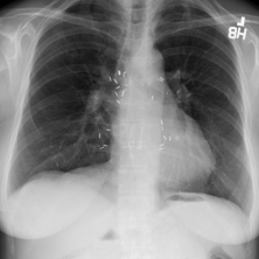

In [37]:
# Ruta a la carpeta del conjunto de datos en Google Drive
data_folders =  ["/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID", "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity",
                 "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal", "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia"]
# Cargar y procesar el conjunto de datos
images = []
labels = []

class_labels = ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

for i, data_folder in enumerate(data_folders):
    image_files = os.listdir(data_folder)
    print(data_folder)
    for filename in image_files:
        image_path = os.path.join(data_folder, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (299, 299))
        # Especificar el tamaño del recorte de bordes
        recorte_bordes = 20

        # Calcular las nuevas dimensiones
        nuevo_alto = 299 - 2 * recorte_bordes
        nuevo_ancho = 299 - 2 * recorte_bordes

        # Recortar la imagen eliminando los bordes
        image = image[recorte_bordes:299-recorte_bordes, recorte_bordes:299-recorte_bordes]

        images.append(image)
        label = i  # Asignar la etiqueta de clase según el índice
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

print(images.shape)
cv2_imshow(images[2])



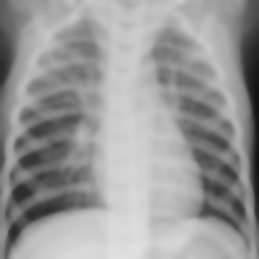

In [39]:
# Dividir el conjunto de datos en entrenamiento y prueba
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Aplicar el filtro bilateral a las imágenes offline y guardarlas
filtered_train_images = np.empty_like(train_images)
filtered_test_images = np.empty_like(test_images)

for i in range(len(train_images)):
    filtered_image = cv2.bilateralFilter(train_images[i], 9, 75, 75)
    filtered_train_images[i] = filtered_image

for i in range(len(test_images)):
    filtered_image = cv2.bilateralFilter(test_images[i], 9, 75, 75)
    filtered_test_images[i] = filtered_image

cv2_imshow(filtered_train_images[2])

In [41]:
# Definir la arquitectura de la CNN
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(259, 259, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Compilar y entrenar la CNN con imágenes en bruto
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))

# Evaluar la CNN con imágenes en bruto
#-----------------------------------------------------------------------------
# Obtener las predicciones del modelo en las imágenes de prueba
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)

# Calcular las métricas
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='macro')
recall = recall_score(test_labels, predictions, average='macro')
f1 = f1_score(test_labels, predictions, average='macro')
#auc_roc = roc_auc_score(test_labels, predictions, average='macro')

# Imprimir las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
#print("AUC-ROC:", auc_roc)
#-----------------------------------------------------------------------------


Epoch 1/10
74/74 [==============================] - 93s 1s/step - loss: 497.6908 - accuracy: 0.8042 - val_loss: 30.5092 - val_accuracy: 0.9134
Epoch 2/10
74/74 [==============================] - 94s 1s/step - loss: 22.8887 - accuracy: 0.9121 - val_loss: 33.4459 - val_accuracy: 0.8608
Epoch 3/10
74/74 [==============================] - 92s 1s/step - loss: 10.5147 - accuracy: 0.9304 - val_loss: 15.2757 - val_accuracy: 0.9236
Epoch 4/10
74/74 [==============================] - 93s 1s/step - loss: 22.6640 - accuracy: 0.8917 - val_loss: 19.9432 - val_accuracy: 0.8727
Epoch 5/10
74/74 [==============================] - 92s 1s/step - loss: 6.8660 - accuracy: 0.9469 - val_loss: 55.9927 - val_accuracy: 0.7674
Epoch 6/10
74/74 [==============================] - 95s 1s/step - loss: 3.6482 - accuracy: 0.9631 - val_loss: 6.6780 - val_accuracy: 0.9423
Epoch 7/10
74/74 [==============================] - 94s 1s/step - loss: 1.5271 - accuracy: 0.9745 - val_loss: 6.6048 - val_accuracy: 0.9474
Epoch 8/10

In [42]:
# Definir una nueva arquitectura de la CNN
model_filtered = keras.models.Sequential()
model_filtered.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(259, 259, 1)))
model_filtered.add(layers.MaxPooling2D((2, 2)))
model_filtered.add(layers.Flatten())
model_filtered.add(layers.Dense(64, activation='relu'))
model_filtered.add(layers.Dense(10, activation='softmax'))

# Compilar y entrenar la CNN con imágenes filtradas
model_filtered.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_filtered.fit(filtered_train_images, train_labels, epochs=10, batch_size=32, validation_data=(filtered_test_images, test_labels))

# Evaluar la CNN con imágenes filtradas
#-----------------------------------------------------------------------------
# Obtener las predicciones del modelo en las imágenes de prueba
predictions = model_filtered.predict(test_images)
predictions = np.argmax(predictions, axis=1)

# Calcular las métricas
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='macro')
recall = recall_score(test_labels, predictions, average='macro')
f1 = f1_score(test_labels, predictions, average='macro')
#auc_roc = roc_auc_score(test_labels, predictions, average='macro')

# Imprimir las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
#print("AUC-ROC:", auc_roc)
#-----------------------------------------------------------------------------


Epoch 1/10
74/74 [==============================] - 92s 1s/step - loss: 425.7813 - accuracy: 0.8149 - val_loss: 46.3186 - val_accuracy: 0.9202
Epoch 2/10
74/74 [==============================] - 92s 1s/step - loss: 30.0992 - accuracy: 0.8972 - val_loss: 15.5899 - val_accuracy: 0.8879
Epoch 3/10
74/74 [==============================] - 92s 1s/step - loss: 4.4677 - accuracy: 0.9359 - val_loss: 4.2593 - val_accuracy: 0.9219
Epoch 4/10
74/74 [==============================] - 91s 1s/step - loss: 1.1945 - accuracy: 0.9626 - val_loss: 1.8503 - val_accuracy: 0.9321
Epoch 5/10
74/74 [==============================] - 90s 1s/step - loss: 0.3887 - accuracy: 0.9737 - val_loss: 1.4881 - val_accuracy: 0.9406
Epoch 6/10
74/74 [==============================] - 92s 1s/step - loss: 0.2012 - accuracy: 0.9826 - val_loss: 1.6431 - val_accuracy: 0.9355
Epoch 7/10
74/74 [==============================] - 90s 1s/step - loss: 0.0602 - accuracy: 0.9898 - val_loss: 1.7899 - val_accuracy: 0.9236
Epoch 8/10
74/7

In [ ]:
print(model.summary())
print(model_filtered.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 5408)              0         
                                                                 
 dense_30 (Dense)            (None, 64)                346176    
                                                                 
 dense_31 (Dense)            (None, 10)                650       
                                                                 
Total params: 347,146
Trainable params: 347,146
Non-trainable params: 0
_______________________________________________